# Transfer Learning

In this demo, we’ll be using the Rock, Paper and Scissors image classification dataset. The purpose of this notebook is to perform Transfer Learning using the Pytorch pre-trained models through DFFML Python API.

The most used types of Transfer Learning are `Fine-Tuning` and `Feature Extraction`.


1.    **Use CNN for Feature Extraction**: Using the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model. In this approach, we generally freeze all the weights of layers except the final layers. In DFFML, the weights of other layers are frozen by setting `trainable = False`, which is also set by default.



2.    **Fine-Tuning the CNN**: Unfreezing the weights of the top layers of a frozen model base and jointly training both the newly-added classifier layers and the last layers of the base model. This is done by setting the parameter `trainable = True`. This part of the tutorial will also focus on showing how to add custom layers to the model to perform fine-tuning of the CNN.

We will be applying the first approach in this tutorial, ie. **Use CNN for Feature Extraction**. In this approach the only difference from **Fine-Tuning the CNN** is essentially setting `trainable = False` rather than `True`. Feel free to try and change the bool value as you please.

## Setting-up

**Import Packages**

Let us import dffml and other packages that we might need.

In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn

from dffml import *
from dffml_model_pytorch import CrossEntropyLossFunction

In [2]:
import asyncio
import nest_asyncio

To use asyncio in a notebook, we need to use nest_asycio.apply()

In [3]:
nest_asyncio.apply()

In [4]:
import sys
import logging
logging.basicConfig(level = logging.INFO, stream=sys.stdout)

**Build our Dataset**

Dffml has a very convinient function `cached_download()` that can be used to download datasets and make sure you don't download them if you have already. We'll be using [cached_download_unpack_archive()](../../api/util/net.rst#dffml.util.net.cached_download_unpack_archive) which also unpacks the file in case its an archived package.

The function has the following parameters:



1. `url (str) `– The URL to download from.

2. `file_path (str, pathlib.Path)` – Path on disk to store the downloaded archive.

3. `directory_path (str, pathlib.Path)` – Path on disk to store extracted contents of downloaded archive.

4. `expected_hash (str)` – SHA384 hash of the contents to verify our download.

5. `protocol_allowlist (list, optional)` – List of strings, one of which the URL must start with. We won't be using this one.

Don't forget to calculate the `expected_hash`, you can find out how at [cached_download_unpack_archive()](../../api/util/net.rst#dffml.util.net.cached_download_unpack_archive)!


In [5]:
train_path = await cached_download_unpack_archive(
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip",
    "train_rps.zip",
    "train_rps",
    "c6a9119b0c6a0907b782bd99e04ce09a0924c0895df6a26bc6fb06baca4526f55e51f7156cceb4791cc65632d66085e8",
)
val_path = await cached_download_unpack_archive(
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip",
    "predict_rps.zip",
    "predict_rps",
    "375457bb95771ffeace2beedab877292d232f31e76502618d25e0d92a3e029d386429f52c771b05ae1c7229d2f5ecc29",
)
test_path = await cached_download_unpack_archive(
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip",
    "test_rps.zip",
    "test_rps",
    "fc45a0ebe58b9aafc3cd5a60020fa042d3a19c26b0f820aee630b9602c8f53dd52fd40f35d44432dd031dea8f30a5f66",
)

Since we are dealing with image data, we'll be utilizing the [DirectorySource](../../api/source/dir.rst) to read and use our data.

In [6]:
train_source = DirectorySource(
    foldername="train_rps/rps",
    feature="image",
    labels=["rock", "paper", "scissors"],
)
test_source = DirectorySource(
    foldername="test_rps/rps-test-set",
    feature="image",
    labels=["rock", "paper", "scissors"],
)
predict_source = DirectorySource(
    foldername="predict_rps",
    feature="image",
)

## Feature Extraction:

### Define our Additional layers

We can do this by using the `torch.nn` module that we imported. First we define our layers in `__init__` and then we define the `forward` function to carry out the forward propagation.

In [7]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.linear1 = nn.Linear(in_features=4096, out_features=256)
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(p = 0.2)
        
        self.linear2 = nn.Linear(in_features=256, out_features=3)

        self.logsoftmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.logsoftmax(self.linear2(x))
        return x

last_layers = ConvNet()

### Instantiate our Model with parameters

Dffml makes it quite easy to load models dynamically using the `Model.load()` function. All the entrypoints for models available in DFFML can be found at the [Model Plugins Page](../../plugins/dffml_model.rst). After that, you just have to parameterize the loaded models and they are ready to train!

In [8]:
Loss = CrossEntropyLossFunction()
AlexnetModel = Model.load("alexnet")

model = AlexnetModel(
    classifications=["rock", "paper", "scissors"],
    features=Features(Feature("image", int, 300 * 300)),
    predict=Feature("label", int, 1),
    location="alexnet",
    pretrained = True,
    trainable = False,
    add_layers = True,
    layers = last_layers,
    epochs=20,
    batch_size=32,
    imageSize=150,
    validation_split=0.2,
    loss=Loss,
    optimizer="Adam",
    enableGPU=True,
)


Note that you can leave out the `trainable` parameter which is essentially setting it to `trainable = False` since that is the default value.
Similarly, you can also leave out the `pre-trained` parameter which is essentially setting it to `pre-trained = True` since that is the default value.

### Train the Model

Finally, our models are ready to be trained using the `high-level` API. Let's make sure to pass each record as a parameter by simply using the unpacking operator(*).

In [9]:
await train(model, train_source)

INFO:dffml.AlexNetModelContext:Using saved model from /home/dffml/examples/notebooks/alexnet/model.pt
INFO:dffml.AlexNetModelContext:------ Record Data ------
INFO:dffml.AlexNetModelContext:x_cols:    2520
INFO:dffml.AlexNetModelContext:y_cols:    2520
INFO:dffml.AlexNetModelContext:-----------------------
INFO:dffml.AlexNetModelContext:Data split into Training samples: 2016 and Validation samples: 504
INFO:dffml.AlexNetModelContext:Epoch 1/20
INFO:dffml.AlexNetModelContext:----------
INFO:dffml.AlexNetModelContext:Training Loss: 0.3729 Acc: 0.9688
INFO:dffml.AlexNetModelContext:Validation Loss: 0.0000 Acc: 1.0000
INFO:dffml.AlexNetModelContext:
INFO:dffml.AlexNetModelContext:Early stopping: Validation Loss didn't improve for 5 consecutive epochs OR maximum accuracy attained.
INFO:dffml.AlexNetModelContext:Training complete in 3m 5s
INFO:dffml.AlexNetModelContext:Best Validation Accuracy: 1.000000


### Test the Model
To test our model, we'll use the `accuracy()` function in the `high-level` API.

We ask for the accuracy to be assessed using the Classification Accuracy method by passing "clf" to `AccuracyScorer.load()`.

In [10]:
ClassificationAccuracy = AccuracyScorer.load("clf")

scorer = ClassificationAccuracy()

Accuracy = await accuracy(model, scorer, test_source)

print("Accuracy = ", Accuracy)

INFO:dffml.AlexNetModelContext:Using saved model from /home/dffml/examples/notebooks/alexnet/model.pt


Accuracy =  0.9327956989247311


### Make predictions using our Model.
Let's make predictions and see what they look like for each model using the `predict` function in the `high-level` API.
Note that the `predict` function returns an asynciterator of a `Record` Object that contains a tuple of record.key, features and predictions.
For the sake of visualizing data, we'll keep the predictions to a few records.

Since we will have more predictions to visualize later on, we'll be creating a helper function to predict on our models and visualize 12 images and their predictions interating through the records. 

In [11]:
async def display_image_predictions(model, prediction_source):
    """
    Display 12 images and their predictions.
    """
    plt.figure(figsize=(20, 20))
    k=1
    async for i, features, prediction in predict(model, prediction_source):
        prediction_label = prediction["label"]["value"]
        prediction_confidence = round(prediction["label"]["confidence"], 2)
        plt.subplot(4,4,k)
        k+=1
        plt.imshow(features['image'])
        title_str = f"{prediction_label} (confidence:{prediction_confidence})"
        plt.title(title_str, fontsize=20)
        plt.axis('off')
        if k > 12:
            break
    plt.show()

Lets call the helper function `display_image_predictions` using `asyncio.run()` to view our predicitons.

INFO:dffml.AlexNetModelContext:Using saved model from /home/dffml/examples/notebooks/alexnet/model.pt


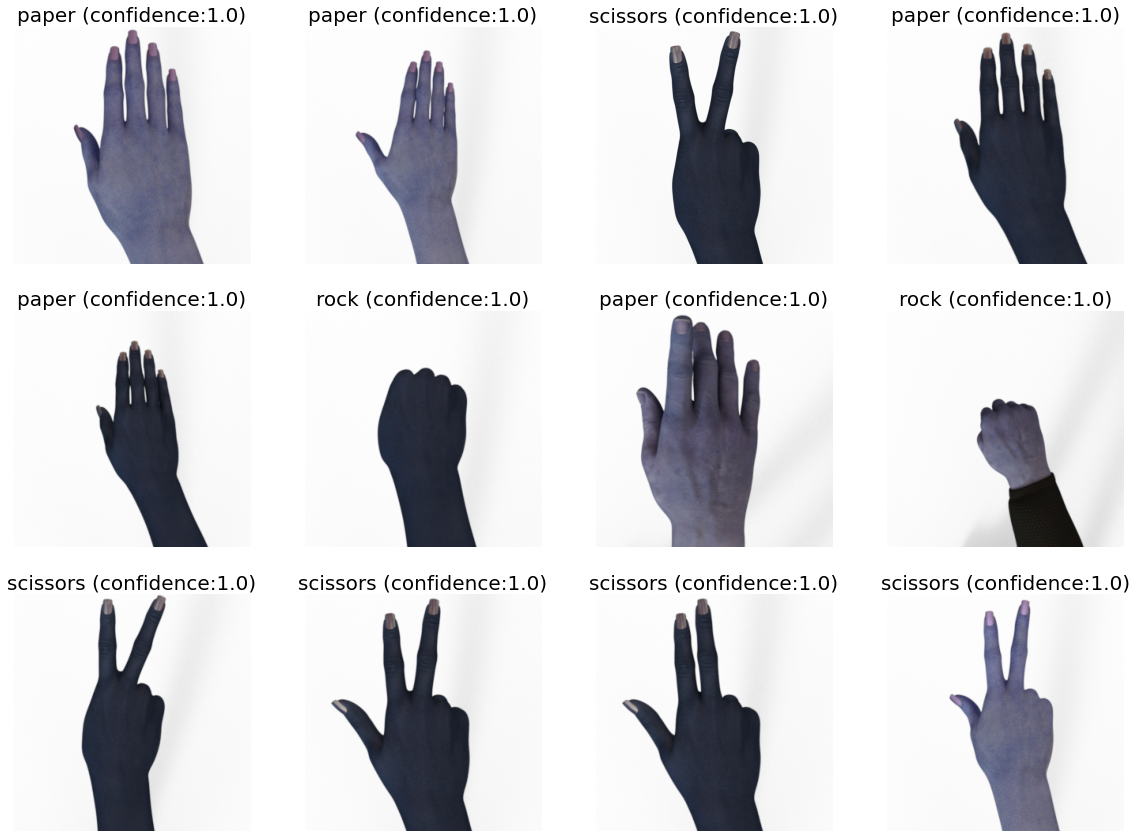

In [12]:
asyncio.run(display_image_predictions(model, predict_source))